###### Problem 1 - a simple distribution

We start with a worked example of a Hierarchical Bayesian Model.  We are going to make some data from a simple Gaussian distribution and add on some observational uncertainty.  We will make the data look like the luminosity (or absolute magnitude) of the red clump.

The distribution of the masses of pumpkins (in kilograms) will be defined as:

$M_{\rm p} \sim \mathcal{N}(4.5, 0.3)$.

If we have $N$ pumpkins which we will label with the index $i = 1,2,..., N$ then

$M_{\rm i, true} \sim \mathcal{N}(4.5, 0.3)$.

For now, assume we have some magic machine that can measure the masses of the pumpkins with an instrumental uncertainty of 0.01kg. The measured masses will be:

$M_{i, {\rm obs}} \sim \mathcal{N}(M_{i, {\rm true}}, 0.6)$.

Let's set up this data.

/home/daniel/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


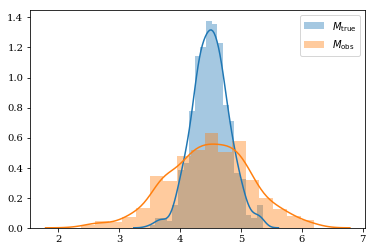

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=12)
%matplotlib inline
import seaborn as sns

N = 500
Mmu = 4.5
Msig = 0.3
M_true = np.random.randn(N) * Msig + Mmu
sigma_M_obs = np.ones(N) * 0.6
M_obs = M_true + np.random.randn(N) * sigma_M_obs

ax = sns.distplot(M_true, label=r'$M_{\rm true}$')
ax = sns.distplot(M_obs, label=r'$M_{\rm obs}$')
ax.legend()

It is immediately obvious, that if we were to try an estimate the spread of masses for the pumpkins from the observed data just by measuring the standard deviation we would find an overestimate.

In [6]:
print(f'Observed data: mean = {M_obs.mean():.4f}; std = {M_obs.std(ddof=1):.4f}; ' + 
      f'error on mean = {M_obs.std(ddof=1) / N**0.5:.4f}')
print(f'True data: mean = {M_true.mean():.4f}; std = {M_true.std(ddof=1):.4f};  ' +
      f'error on mean = {M_true.std(ddof=1) / N**0.5:.4f}')

Observed data: mean = 4.4842; std = 0.6429; error on mean = 0.0288
True data: mean = 4.5123; std = 0.2946;  error on mean = 0.0132


What we want is a method that takes the observed data and estimates the spread in the true data.  I guess this can be done a number of ways but here we will look at an HBM using latent variables.  This HBM method will scale very nicely with more complex problems.

Let's jump right in a build an acyclic graph to visualise our problem:

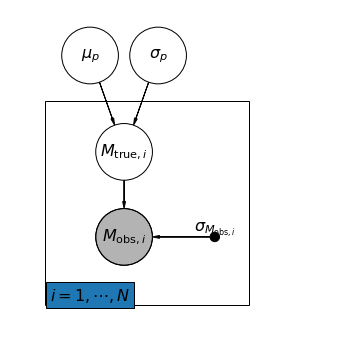

In [8]:
''' You might need to pip install daft and update matplotlib to get this to work '''

from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu_{p}$", 0.7, 2.6))
pgm.add_node(daft.Node("sigma", r"$\sigma_{p}$", 1.3, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("M_true", r"$M_{{\rm true},i}$", 1, 1.75))
# Data.
pgm.add_node(daft.Node("M_obs", r"$M_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("err", r"$\sigma_{M_{{\rm obs},i}}$", 1.8, 1.0, fixed=True, offset=[0.4,0.4]))
# Add in the edges.
pgm.add_edge("mu", "M_true")
pgm.add_edge("sigma", "M_true")
pgm.add_edge("M_true", "M_obs")
pgm.add_edge("err", "M_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.3, 0.5, 1.8, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

The pumpkin magnitudes are assumed to follow a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$; both of which are unknowns.  Each pumpkin in $N$ has an index $i$.  Each pumpkin also has a true mass, which is an unknown, and an observed mass which is known with some uncertainty $\sigma_{M_{{\rm obs},i}}$.  We then treat $\mu$, $\sigma$, and $[M_{{\rm true}, 1}, M_{{\rm true}, 2}, ..., M_{{\rm true}, N}]$ as parameters that are to be estimated.  

We have the following constraints:

$M_{\rm true} \sim \mathcal{N}(M_{\rm obs}, \sigma_{M_{{\rm obs}}})$.

That is, the true values of the clump K-band magnitude must be consistent with the observed values and their uncertainties.

$M_{\rm true} \sim \mathcal{N}(\mu, \sigma)$.

Which is to say, that the distribution of $K_{\rm true}$ should be consistent with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

We will also add the following priors that represent our exisitng knowledge of the red clump but are designed to be weakly informative:

$\mu \sim \mathcal{N}\left({4.5, 0.8}\right)$,

and 

$\sigma \sim {\rm Lognormal}(\log(0.8), 0.4)$,

We can code this up in stan easily!  Before we do, a quick example of the lognormal distribution:

/home/daniel/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


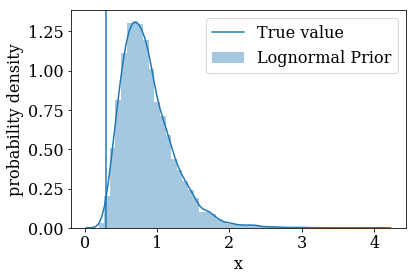

In [11]:
x = np.random.lognormal(np.log(0.8), 0.4, 10000)
ax = sns.distplot(x, label='Lognormal Prior')
ax.axvline(Msig, label='True value')
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.legend()

In [12]:
code = '''
data {
    int N;  // N pumpkins
    real Mobs[N];
    real sigmaMobs[N];
}
parameters {
    real mu;
    real<lower = 0> sigma;
    real Mtrue[N];
}
model {
    Mtrue ~ normal(Mobs, sigmaMobs);
    Mtrue ~ normal(mu, sigma);
    mu ~ normal(-4.5, 0.6);
    sigma ~ lognormal(log(0.8), 0.4);
}

'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8320de484de6a9061eac6a0b0abf1f9c NOW.


The stan code is written here as a string that is passed to the StanModel object.

The first section defines the data.  Both Kobs and sigmaKobs are arrays of length N with type real.

The second section defines the parameters.  Note here we have included a lower limit on sigma of zero - negative spread does not mean much here.  We have also defined an array of parameters!  Ktrue is an array of length N.  Stan understands this and treats each value in the array as a parameter (see below).

The final section defines the model.  Here we have just made the statements we defined above about what the constraints we have are.  There are two hyper-priors on mu and sigma.  And then there are the constraints on Ktrue from Kobs and the constraint on Ktrue from $\mu$ and $\sigma$.

The code 'sm = pystan.StanModel(model_code=code)' compiles the stan model for us to call later.

We can now run the code.

In [15]:
nchains = 1
data = {'N': N,
       'Mobs': M_obs,
       'sigmaMobs': sigma_M_obs}
fit = sm.sampling(data=data, iter=2000, chains=nchains)

Running the code is simple.  We first make a choice as to how many chains we want to run in Stan's HMC sampler.  A default for testing is 4 chains but you might want to increase that number for important work.

We then define a dictionary called data that holds that data objects defined in the model so that these can be passed in to the sampling method.

Finally, we fit by calling sm.sampling() passing in data, running for 2000 iterations, and setting the number of chains.

You can watch the fit proceed in the terminal window.  Running on my laptop, the fit took less than 2 seconds (note the compliation takes significantly longer).

The fit object has a plot method so we can view the results.

In [ ]:
fit.plot()
plt.show()

We can print the fit object to see lots of useful information.  Perhaps most importantly, Rhat gives a measure of convergence.  The closer Rhat is to unity the better.  Experience suggests that all Rhat's less than 1.02 should give reasonable results.

In [17]:
print(fit)

Inference for Stan model: anon_model_8320de484de6a9061eac6a0b0abf1f9c.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           4.46  2.1e-3   0.03    4.4   4.44   4.46   4.48   4.52    200   1.01
sigma        0.28    0.01   0.04   0.18   0.25   0.28   0.31   0.36     20   1.15
Mtrue[1]     4.48  6.8e-3   0.27   3.96    4.3   4.48   4.65   5.03   1566    1.0
Mtrue[2]     4.51  7.8e-3   0.25   3.98   4.36   4.51   4.67    5.0   1018    1.0
Mtrue[3]     4.57  7.0e-3   0.26   4.07    4.4   4.56   4.73    5.1   1330    1.0
Mtrue[4]     4.29  7.7e-3   0.27   3.76   4.12   4.31   4.48   4.78   1212   1.01
Mtrue[5]     4.44  8.0e-3   0.26    3.9   4.26   4.43   4.61   4.96   1083    1.0
Mtrue[6]     4.48  7.6e-3   0.25   3.98   4.33   4.48   4.65   5.01   1103    1.0
Mtrue[7]     4.36  7.7e-3   0.26   3.84   4.19   4.35   4.54   4.84   116

We can also study the detail of the fit using corner.

In [18]:
import corner

data = np.vstack([fit['mu'], fit['sigma']]).T
corner.corner(data, labels=[r'$\mu$', r'$\sigma$'], truths=[RCK, RCS])
plt.show()

NameError: name 'RCK' is not defined

We can see that we do a good job of recovering the real properties of the population (Ktrue).  

Here we have worked through a simple example of Hirarchical modelling in Stan.  We have treated this very simply and shown how to take a first look at the fit results of a StanModel sampling result.

In the next example, I will demonstrate another simple problem but with a sampling 'trick' that will speed up convergence considerably for lots of different applications of this simple problem.